In [47]:
using DataFrames, Dates
using StatsBase: maximum, minimum, median, mean, countmap
import PlotlyJS
include("../Sensors/sensors.jl")
include("../PreProcessing/preprocessing.jl")
include("../helpers.jl")
include("../visualizations.jl");

## Load the data and format it

In [48]:
datafolder = "../../Data/Twitter/"
datafile = datafolder * "all_links_processed.json"
data = load_json(datafile)

#=
datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)
=#
data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");

## Define the partition, actors and actions

In [49]:
part_fun = sentiment#cop_26_dates
actor_fun = follower_count
action_fun = trust_popularity_score_old#trust_score

clean_dates = x -> floor(x, Dates.Minute(5*60));
data.time = clean_dates.(data."created_at");

df = data |> part_fun |> action_fun |> actor_fun;

## Compute influence graph

In [50]:
tsg = TimeSeriesGenerator()
time_series = observe(df, tsg)

ig = InfluenceGrapher()
influence_graph = observe(time_series, ig);

## Compte influence cascade and plot influence graph

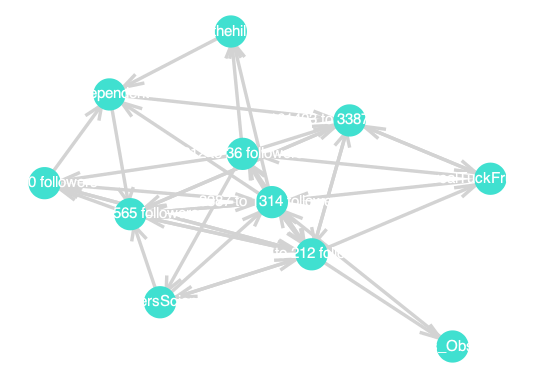

In [51]:
begin
	function make_simplifier(edge_type)
		if edge_type=="Any Edge"
			return x->(maximum(x)>cuttoff)
		else
			idx = findfirst(x->(x==et), edgeTypes)
			return x->(x[idx]>cuttoff)
		end
	end

	et = "Any Edge"
	s = make_simplifier(et)

	cuttoff = 0.5
	icg = InfluenceCascadeGenerator(cuttoff)
	influence_cascades = observe.(influence_graph, Ref(icg))

	
	partitions = unique(df[!,tsg.part_col])
	part = "neutral"
	i = (1:length(partitions))[findfirst(x->x==part, partitions)]
	
	# In this case we plot the graph on a world map
	if actor_fun == country
		PlotlyJS.plot(map_plot(df)...)
	# In this case we plot a simple graph of the actors
	else
		#gplot(g, xs, ys, nodelabel=unique(df.actor))
		plot_graph(influence_graph[i], df, simplifier=s)
	end
	
end

In [56]:
partition_index = (1:length(partitions))[findfirst(part .== partitions)]
influencer_indices = [ic.root for ic in influence_cascades[partition_index]]
influencers = unique(df.actor)[influencer_indices]

6-element Vector{String}:
 "DerekCressman"
 "tveitdal"
 "grist"
 "ClimateReality"
 "ScienceNews"
 "CBCNews"

In [53]:
infl = unique(df.actor)[influencers]
influencer_node1 = infl[1]
influencer_node2 = infl[1]

PlotlyJS.plot(plot_cascade_sankey(
	influence_cascades[findfirst(x->x==part,unique(df[!, tsg.part_col]))][findfirst(x->x==influencer_node1, unique(df[!, tsg.actor_col])[influencers])],
	unique(df[!, tsg.action_col]))...)

LoadError: ArgumentError: unable to check bounds for indices of type String

In [ ]:
#PlotlyJS.savefig(PlotlyJS.plot(plot_cascade_sankey(
#	influence_cascades[2][4], unique(df[!, tsg.action_col]))...), "sankey.png")

In [ ]:
PlotlyJS.plot(plot_cascade_sankey(
influence_cascades[2][3], unique(df[!, tsg.action_col]))...)

In [ ]:
show(plot_actors_per_level(influence_cascades, df))

In [ ]:
plot_actor_wordcloud(df, Nactor=300)

In [ ]:
show(plot_actor_frequency(df))

In [ ]:
show(plot_action_frequency(df, split_by_partition = true))

In [ ]:
show(plot_action_frequency_v2(df, split_by_partition = true))

In [ ]:
a = countmap(df[!, "username"])

In [ ]:
key = collect(keys(a))
val = collect(values(a))

foo = key[val .> 10]

In [ ]:
function foo(a::Int)
    return Vector{Int}()
end

test = [1,2,3]
b = foo.(test)


In [ ]:
all(isempty(i) for i in b)

In [ ]:
5 % 3

In [ ]:
5 ÷ 3